# Data Driven Solution - Part I

## Imports

In [3]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

# Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import BSpline
import pandas as pd

# Graphing Libraries
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For Train - Validation - Test
from sklearn.model_selection import train_test_split

# For collocation points
from pyDOE import lhs
print(tf.__version__)

%matplotlib inline
# %matplotlib notebook
# Tensorboard

Using TensorFlow backend.


1.13.1


## Load Data

In [4]:
# Set Random Seed
np.random.seed(101)
tf.set_random_seed(101)

data = loadmat('./burgers_shock.mat'); 

x = pd.Series(data['x'].flatten())[:, None]
t = pd.Series(data['t'].flatten())[:, None]
u_data = np.real(data['usol']).T
usol = pd.Series(u_data.flatten())[:, None]

print(f'u shape: {usol.shape}')
print(f'x train shape: {x.shape}')
print(f't train shape: {t.shape}')

u shape: (25600, 1)
x train shape: (256, 1)
t train shape: (100, 1)


In [5]:
X, T = np.meshgrid(x, t); 

In [6]:
X_data = pd.DataFrame(np.hstack((X.flatten()[:, None], 
                                 T.flatten()[:, None])));

X_data.columns = ['X', 'T'];

X_data.head()

,X,T
0,-1.000000,0.0
1,-0.992157,0.0
2,-0.984314,0.0
3,-0.976471,0.0
4,-0.968627,0.0


## Boundary Conditions

#### At t = 0

In [7]:
x_t_at_initial_time_condition = np.hstack((X[0:1, :].T, T[0:1, :].T))
u_at_initial_time = (u_data[0, :].T)[:, None];

#### At x = -1

In [8]:
x_t_at_negative_boundary = np.hstack((X[:, 0:1], T[:, 0:1]))
u_at_negative_boundary = u_data[:, 0:1]

#### At x = 1

In [9]:
x_t_at_positive_boundary = np.hstack((X[:, -1:], T[:, -1:]))
u_at_positive_boundary = u_data[:, -1:]

#### X_u_train

In [10]:
X_u_train = np.vstack([x_t_at_initial_time_condition, 
                       x_t_at_negative_boundary,
                       x_t_at_positive_boundary])

#### u_train

In [11]:
u_train = np.vstack([u_at_initial_time,
                     u_at_negative_boundary,
                     u_at_positive_boundary])

## Train Test Split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_data, usol, 
                                                  test_size = 0.3, 
                                                  random_state = 101)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                test_size = 0.4,
                                                random_state = 101)

In [13]:
print(f'Training Data: {X_train.shape}')
print(f'Validation shape: {X_val.shape}')
print(f'Test shape: {X_test.shape}')
print(f'Total Points: {len(X_train) + len(X_val) + len(X_test)}')

Training Data: (17920, 2)
Validation shape: (4608, 2)
Test shape: (3072, 2)
Total Points: 25600


## Functions

In [14]:
def init_weights(shape):
    input_size, output_size = shape[0], shape[1]
    std = np.sqrt(2/(input_size + output_size))
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist, dtype = tf.float32)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def initial_nn(layers):
    weights = []
    biases = []
    
    for index in range(len(layers)-1):
        shape=(layers[index], layers[index + 1])
        W = init_weights(shape)
        b = init_bias((1, layers[index + 1]))
        weights.append(W)
        biases.append(b)
    return weights, biases
     

In [15]:
def neural_net(x, t, weights, biases):
    
    X = tf.concat([t, x], 1)
    num_layers = len(weights) + 1
    
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        X = tf.tanh(tf.add(tf.matmul(X, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(X, W), b)
    
    return Y
            

In [16]:
def f_net(x, t, weights, biases):
    nu = 0.01/np.pi
    u = neural_net(x, t, weights, biases)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u*u_x - nu*u_xx
    return f

In [17]:
def stratify_sample(num_samples, X_data, num_factors = 2):
    '''
    Variables are sampled using a even sampling method, 
    and then randomly combined sets of those variables 
    are used for one calculation of the target function.   
    '''
    lower_bound = X_data.min(0)
    upper_bound = X_data.max(0)
    bound_range = upper_bound - lower_bound
    
    result = lower_bound + bound_range * lhs(num_factors, num_samples)
    return result
  

In [18]:
def physics_nn(layers, x_u, t_u, x_f, t_f, weights, biases):    
    u_predictions = neural_net(x_u, t_u, weights, biases)
    f_predictions = f_net(x_f, t_f, weights, biases)
    return u_predictions, f_predictions

In [19]:
def callback(loss):
    print('Loss:', loss)

In [20]:
def joint_loss(u_u, u_predictions, f_predictions):
    u_loss = tf.reduce_mean(tf.square(u_u - u_predictions))
    f_loss = tf.reduce_mean(tf.square(f_predictions))
    total_loss = tf.add(u_loss, f_loss)
    return total_loss
    

In [21]:
def plot_history(num_steps, loss_history):
    plt.plot(range(num_steps), loss_history)
    plt.title('Loss v. Iterations');
    plt.ylabel('Loss');
    plt.xlabel('Iterations');

## Model Parameters

In [22]:
N_f = 10000
N_u = 100

In [23]:
lower_bound = np.array(X_data.min(0))
upper_bound = np.array(X_data.max(0))

In [24]:
upper_bound

array([1.  , 0.99])

In [25]:
X_f_data = stratify_sample(N_f, X_u_train); 

In [26]:
X_f_data

array([[ 0.44956223,  0.09455335],
       [-0.5342242 ,  0.53650042],
       [-0.46532888,  0.08034628],
       ...,
       [-0.18177638,  0.13322691],
       [ 0.12594875,  0.49823681],
       [-0.19260854,  0.19251179]])

In [27]:
X_f_train = np.vstack((X_f_data, X_u_train))
print(f'Stacked/Collocated Points: {X_f_train.shape}')

Stacked/Collocated Points: (10456, 2)


In [28]:
LAYERS = [2, 50, 50, 1]

In [29]:
random_idx = np.random.choice(X_u_train.shape[0], N_u, replace = False)

In [30]:
X_u_train = X_u_train[random_idx, :]
u_train = u_train[random_idx, :]

## Model Initialization

In [31]:
class PhysicsInformedNN():
    
    def __init__(self, X_u, u, X_f, layers, num_iter, lower_bound, upper_bound):
        
        self.loss_history = []  
        self.num_iter, self.layers = num_iter, layers
        self.u = u
        self.lower_bound, self.upper_bound = lower_bound, upper_bound
        self.x_u, self.t_u = X_u[:, 0][:, None], X_u[:, 1][:, None]
        self.x_f, self.t_f = X_f[:, 0][:, None], X_f[:, 1][:, None]
        
        self.weights, self.biases = self.initial_nn(layers)
        
        self.x_u_tf, self.t_u_tf, self.u_tf, self.x_f_tf, self.t_f_tf = self.generate_placeholders()
        
        self.u_pred, self.f_pred = self.generate_predictions()
        
        self.loss = self.calc_loss()
        
        config = tf.ConfigProto(allow_soft_placement = True, 
                                log_device_placement = True)
        options = {
            'maxiter': num_iter,
            'maxfun':  num_iter,
            'maxcor': 50, 
            'maxls': 50,
            'ftol' : 1.0 * np.finfo(float).eps
        }
        
        self.sess = tf.Session(config = config)
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B',
                                                                options = options)
                                                                
        self.sess.run(tf.global_variables_initializer())
        
        
    def train(self):
        tf_dict = {
            self.x_u_tf: self.x_u, 
            self.t_u_tf: self.t_u, 
            self.u_tf: self.u, 
            self.x_f_tf: self.x_f, 
            self.t_f_tf: self.t_f
        }                                                                                                                 
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.loss], 
                                loss_callback = self.callback)
    
    def predict(self, X_data):
        predict_dict = {
            self.x_u_tf: X_data.iloc[:,0][:, None], 
            self.t_u_tf: X_data.iloc[:,1][:, None]
        }
        
        u_predictions = self.sess.run(self.u_pred, feed_dict = predict_dict)  
#         f_predictions = self.sess.run(self.f_pred, feed_dict = predict_dict)
        return u_predictions
        
    def callback(self, loss):
        print('Loss:', round(loss, 4))
        self.loss_history.append(loss)
        
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        h = 2.0*(X - self.lower_bound)/(self.upper_bound - self.lower_bound) - 1.0
        for l in range(0,num_layers - 2):
            W = weights[l]
            b = biases[l]
            h = tf.tanh(tf.add(tf.matmul(h, W), b))   
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(h, W), b)
        return Y
    
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t], 1, name='00_concat_op'), self.weights, self.biases)
        return u
            
    def net_f(self, x, t):
        nu = 0.01 / np.pi
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + u*u_x - nu*u_xx
        return f
    
    def calc_loss(self):
        u_loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) 
        f_loss = tf.reduce_mean(tf.square(self.f_pred))  
        return u_loss + f_loss
               
    def generate_predictions(self):
        u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        return u_pred, f_pred
        
    def generate_placeholders(self):
        x_u_tf = tf.placeholder(tf.float32)
        t_u_tf = tf.placeholder(tf.float32)        
        
        u_tf = tf.placeholder(tf.float32)
        
        x_f_tf = tf.placeholder(tf.float32)
        t_f_tf = tf.placeholder(tf.float32)
        
        return x_u_tf, t_u_tf, u_tf, x_f_tf, t_f_tf
        
    def init_weights(self, shape):
        input_size, output_size = shape[0], shape[1]
        std = np.sqrt(2/(input_size + output_size))
        init_random_dist = tf.truncated_normal(shape, stddev = std)
        return tf.Variable(init_random_dist, dtype = tf.float32)

    def init_bias(self, shape):
        init_bias_vals = tf.constant(0.1, shape = shape)
        return tf.Variable(init_bias_vals)

    def initial_nn(self, layers):
        weights = []
        biases = []

        for index in range(len(layers)-1):
            shape = (layers[index], layers[index + 1])
            W = init_weights(shape)
            b = init_bias((1, layers[index + 1]))
            weights.append(W)
            biases.append(b)       
        return weights, biases

        

## Run Model

In [32]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, 
                          layers = LAYERS, 
                          num_iter = 2000, 
                          lower_bound = lower_bound, upper_bound = upper_bound)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [33]:
model.train()

Loss: 0.3119
Loss: 1.1642
Loss: 0.2712
Loss: 0.2416
Loss: 0.2281
Loss: 0.2271
Loss: 0.227
Loss: 0.227
Loss: 0.227
Loss: 0.2268
Loss: 0.2264
Loss: 0.2246
Loss: 0.816
Loss: 0.2242
Loss: 0.2312
Loss: 0.2231
Loss: 0.2217
Loss: 0.2196
Loss: 0.2195
Loss: 0.2194
Loss: 0.2192
Loss: 0.2188
Loss: 0.2176
Loss: 0.2149
Loss: 0.2109
Loss: 0.224
Loss: 0.2003
Loss: 2.1627
Loss: 0.1955
Loss: 0.1917
Loss: 0.1862
Loss: 0.1789
Loss: 0.1749
Loss: 0.1715
Loss: 0.1636
Loss: 0.1512
Loss: 0.1408
Loss: 0.1271
Loss: 0.1219
Loss: 0.1213
Loss: 0.1198
Loss: 0.119
Loss: 0.1169
Loss: 0.1118
Loss: 0.1083
Loss: 0.1073
Loss: 0.1065
Loss: 0.1054
Loss: 0.1047
Loss: 0.1038
Loss: 0.1032
Loss: 0.1024
Loss: 0.1015
Loss: 0.1004
Loss: 0.0972
Loss: 0.0951
Loss: 0.0946
Loss: 0.0947
Loss: 0.0943
Loss: 0.0942
Loss: 0.094
Loss: 0.0938
Loss: 0.0932
Loss: 0.0914
Loss: 0.0905
Loss: 0.0899
Loss: 0.0895
Loss: 0.0891
Loss: 0.0888
Loss: 0.088
Loss: 0.0866
Loss: 0.0856
Loss: 0.0837
Loss: 0.0822
Loss: 0.0814
Loss: 0.0824
Loss: 0.0807
Loss: 0

Loss: 0.0266
Loss: 0.0266
Loss: 0.0265
Loss: 0.0265
Loss: 0.0265
Loss: 0.0265
Loss: 0.0265
Loss: 0.0264
Loss: 0.0264
Loss: 0.0264
Loss: 0.0264
Loss: 0.0264
Loss: 0.0263
Loss: 0.0263
Loss: 0.0263
Loss: 0.0262
Loss: 0.0262
Loss: 0.0262
Loss: 0.0261
Loss: 0.0261
Loss: 0.0261
Loss: 0.0262
Loss: 0.026
Loss: 0.026
Loss: 0.026
Loss: 0.026
Loss: 0.0259
Loss: 0.0259
Loss: 0.0261
Loss: 0.0258
Loss: 0.0258
Loss: 0.0257
Loss: 0.0257
Loss: 0.0257
Loss: 0.0257
Loss: 0.0257
Loss: 0.0256
Loss: 0.0256
Loss: 0.0256
Loss: 0.0255
Loss: 0.0255
Loss: 0.0255
Loss: 0.0255
Loss: 0.0254
Loss: 0.0254
Loss: 0.0254
Loss: 0.0253
Loss: 0.0253
Loss: 0.0253
Loss: 0.0252
Loss: 0.0252
Loss: 0.0252
Loss: 0.0251
Loss: 0.0251
Loss: 0.025
Loss: 0.025
Loss: 0.025
Loss: 0.0251
Loss: 0.025
Loss: 0.0249
Loss: 0.0249
Loss: 0.0249
Loss: 0.0249
Loss: 0.0248
Loss: 0.0248
Loss: 0.0248
Loss: 0.0247
Loss: 0.0247
Loss: 0.0247
Loss: 0.0246
Loss: 0.0246
Loss: 0.0245
Loss: 0.0244
Loss: 0.0244
Loss: 0.0244
Loss: 0.0243
Loss: 0.0243
Loss: 0

Loss: 0.0069
Loss: 0.0068
Loss: 0.0068
Loss: 0.0068
Loss: 0.0068
Loss: 0.0067
Loss: 0.0067
Loss: 0.0067
Loss: 0.0067
Loss: 0.0067
Loss: 0.0067
Loss: 0.0067
Loss: 0.0066
Loss: 0.0066
Loss: 0.0066
Loss: 0.0067
Loss: 0.0066
Loss: 0.0066
Loss: 0.0066
Loss: 0.0066
Loss: 0.0066
Loss: 0.0065
Loss: 0.0065
Loss: 0.0065
Loss: 0.0085
Loss: 0.0065
Loss: 0.0065
Loss: 0.0065
Loss: 0.0065
Loss: 0.0065
Loss: 0.0065
Loss: 0.0065
Loss: 0.0065
Loss: 0.0064
Loss: 0.0064
Loss: 0.0064
Loss: 0.0064
Loss: 0.0064
Loss: 0.0064
Loss: 0.0063
Loss: 0.0063
Loss: 0.0063
Loss: 0.0063
Loss: 0.0063
Loss: 0.0063
Loss: 0.0063
Loss: 0.0063
Loss: 0.0063
Loss: 0.0062
Loss: 0.0065
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0062
Loss: 0.0061
Loss: 0.0061
Loss: 0.0061
Loss: 0.0061
Loss: 0.0061
Loss: 0.0061
Loss: 0.0061
Loss: 0.006
Loss: 0.006
Loss: 0.006
Loss: 0.006
Loss: 0.006
Loss: 0.006
Loss: 0.0059
Loss: 0.0059
Loss: 0.0059
Loss: 0.0059
Loss:

Loss: 0.003
Loss: 0.003
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0031
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0029
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0029
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
Loss: 0.0028
L

In [34]:
def filter_cost_for_outliers(history, num_passes):
    for i in range(num_passes):
        idx = history.index(max(history))
        history[idx] = np.mean([history[idx -1], history[idx + 1]])

In [35]:
# filter_cost_for_outliers(model.loss_history, num_passes = 10)

In [36]:
# plt.plot(num_steps, loss);
# plt.xlabel('Num Iterations');
# plt.ylabel('Loss');
# plt.title('Cost Function');

## Predictions

In [37]:
u_pred = model.predict(X_data);

In [38]:
error_u = np.linalg.norm(usol - u_pred,2)/np.linalg.norm(usol,2)
print('Error u: %e' % (error_u))                     

Error u: 1.557930e-01


In [39]:
U_pred = griddata(X_data, u_pred.flatten(), (X, T), method='cubic')

## Plotting

### Subplots

In [58]:
def plot_subplots():
    extent = [0, 1, -1, 1]
    params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(params)

    fig = plt.figure(figsize = (10, 10))
    fig.subplots_adjust(hspace = 0.5)
    gs = fig.add_gridspec(2, 1)
    
    ax1 = fig.add_subplot(gs[0, :], )
    ax1.set_title('Actual Data', color = 'white')
    ax1.set_xlabel('time')
    ax1.set_ylabel('x')
    h = ax1.imshow(u_data.T, 
                   interpolation ='gaussian', cmap ='jet', 
                   extent = extent, 
                   origin ='lower', aspect ='auto')
    plt.colorbar(h);


    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('Predicted Data', color ='white')
    ax2.set_xlabel('time')
    ax2.set_ylabel('x')
    h = ax2.imshow(U_pred.T, interpolation='gaussian', cmap='jet', 
                   extent = extent, 
                   origin='lower', aspect='auto')
    plt.colorbar(h);
   

    plt.savefig('./images/burgers_partI', dpi = 1200, transparent = True)

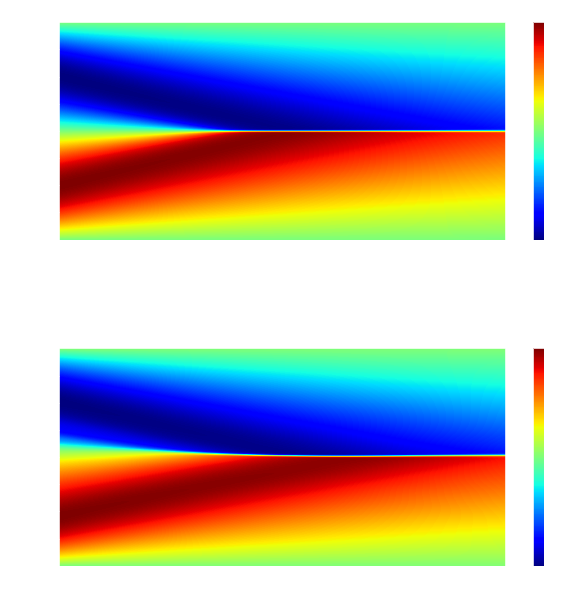

In [59]:
plot_subplots()

# Data Driven Discovery - Part II

## Imports

In [1]:
import time

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

# Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import BSpline
import pandas as pd

# Graphing Libraries
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For Train - Validation - Test
from sklearn.model_selection import train_test_split

# For collocation points
from pyDOE import lhs
print(tf.__version__)

%matplotlib inline
# %matplotlib notebook
# Tensorboard

Using TensorFlow backend.


1.13.1


## Load Data

In [2]:
# Set Random Seed
np.random.seed(1234)
tf.set_random_seed(1234)

data = loadmat('./burgers_shock.mat'); 

x = pd.Series(data['x'].flatten())[:, None]
t = pd.Series(data['t'].flatten())[:, None]
u_data = np.real(data['usol']).T
usol = pd.Series(u_data.flatten())[:, None]

print(f'u shape: {usol.shape}')
print(f'x train shape: {x.shape}')
print(f't train shape: {t.shape}')

u shape: (25600, 1)
x train shape: (256, 1)
t train shape: (100, 1)


In [6]:
x

array([[-1.        ],
       [-0.99215686],
       [-0.98431373],
       [-0.97647059],
       [-0.96862745],
       [-0.96078431],
       [-0.95294118],
       [-0.94509804],
       [-0.9372549 ],
       [-0.92941176],
       [-0.92156863],
       [-0.91372549],
       [-0.90588235],
       [-0.89803922],
       [-0.89019608],
       [-0.88235294],
       [-0.8745098 ],
       [-0.86666667],
       [-0.85882353],
       [-0.85098039],
       [-0.84313725],
       [-0.83529412],
       [-0.82745098],
       [-0.81960784],
       [-0.81176471],
       [-0.80392157],
       [-0.79607843],
       [-0.78823529],
       [-0.78039216],
       [-0.77254902],
       [-0.76470588],
       [-0.75686275],
       [-0.74901961],
       [-0.74117647],
       [-0.73333333],
       [-0.7254902 ],
       [-0.71764706],
       [-0.70980392],
       [-0.70196078],
       [-0.69411765],
       [-0.68627451],
       [-0.67843137],
       [-0.67058824],
       [-0.6627451 ],
       [-0.65490196],
       [-0

In [52]:
X, T = np.meshgrid(x, t); 

In [53]:
X_data = pd.DataFrame(np.hstack((X.flatten()[:, None], 
                                 T.flatten()[:, None])));

X_data.columns = ['X', 'T'];

X_data.head()

,X,T
0,-1.000000,0.0
1,-0.992157,0.0
2,-0.984314,0.0
3,-0.976471,0.0
4,-0.968627,0.0


## Boundary Conditions

#### At t = 0

In [54]:
x_t_at_initial_time_condition = np.hstack((X[0:1, :].T, T[0:1, :].T))
u_at_initial_time = (u_data[0, :].T)[:, None];

#### At x = -1

In [55]:
x_t_at_negative_boundary = np.hstack((X[:, 0:1], T[:, 0:1]))
u_at_negative_boundary = u_data[:, 0:1]

#### At x = 1

In [56]:
x_t_at_positive_boundary = np.hstack((X[:, -1:], T[:, -1:]))
u_at_positive_boundary = u_data[:, -1:]

#### X_u_train

In [57]:
X_u_train = np.vstack([x_t_at_initial_time_condition, 
                       x_t_at_negative_boundary,
                       x_t_at_positive_boundary])
X_u_train.shape

(456, 2)

#### u_train

In [58]:
u_train = np.vstack([u_at_initial_time,
                     u_at_negative_boundary,
                     u_at_positive_boundary])

## Train Test Split

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X_data, usol, 
                                                  test_size = 0.3, 
                                                  random_state = 101)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                test_size = 0.4,
                                                random_state = 101)

In [60]:
print(f'Training Data: {X_train.shape}')
print(f'Validation shape: {X_val.shape}')
print(f'Test shape: {X_test.shape}')
print(f'Total Points: {len(X_train) + len(X_val) + len(X_test)}')

Training Data: (17920, 2)
Validation shape: (4608, 2)
Test shape: (3072, 2)
Total Points: 25600


## Functions

In [61]:
def init_weights(shape):
    input_size, output_size = shape[0], shape[1]
    std = np.sqrt(2/(input_size + output_size))
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist, dtype = tf.float32)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def initial_nn(layers):
    weights = []
    biases = []
    
    for index in range(len(layers)-1):
        shape =(layers[index], layers[index + 1])
        W = init_weights(shape)
        b = init_bias((1, layers[index + 1]))
        weights.append(W)
        biases.append(b)
    return weights, biases
     

In [62]:
def neural_net(x, t, weights, biases):
    
    X = tf.concat([t, x], 1)
    num_layers = len(weights) + 1
    
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        X = tf.tanh(tf.add(tf.matmul(X, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(X, W), b)
    
    return Y
            

In [63]:
def f_net(x, t, weights, biases):
    nu = 0.01/np.pi
    u = neural_net(x, t, weights, biases)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u*u_x - nu*u_xx
    return f

In [64]:
def stratify_sample(num_samples, X_data, num_factors = 2):
    '''
    Variables are sampled using a even sampling method, 
    and then randomly combined sets of those variables 
    are used for one calculation of the target function.   
    '''
    lower_bound = X_data.min(0)
    upper_bound = X_data.max(0)
    bound_range = upper_bound - lower_bound
    
    result = lower_bound + bound_range * lhs(num_factors, num_samples)
    return result
  

In [65]:
def physics_nn(layers, x_u, t_u, x_f, t_f, weights, biases):    
    u_predictions = neural_net(x_u, t_u, weights, biases)
    f_predictions = f_net(x_f, t_f, weights, biases)
    return u_predictions, f_predictions

In [66]:
def callback(loss):
    print('Loss:', loss)

In [67]:
def joint_loss(u_u, u_predictions, f_predictions):
    u_loss = tf.reduce_mean(tf.square(u_u - u_predictions))
    f_loss = tf.reduce_mean(tf.square(f_predictions))
    total_loss = tf.add(u_loss, f_loss)
    return total_loss
    

In [68]:
def plot_history(num_steps, loss_history):
    plt.plot(range(num_steps), loss_history)
    plt.title('Loss v. Iterations');
    plt.ylabel('Loss');
    plt.xlabel('Iterations');

## Model Parameters

In [69]:
N_f = 10000
N_u = 2000

In [70]:
lower_bound = np.array(X_data.min(0))
upper_bound = np.array(X_data.max(0))

In [71]:
lower_bound

array([-1.,  0.])

In [72]:
X_f_data = stratify_sample(N_f, X_u_train); 

In [73]:
X_f_train = np.vstack((X_f_data, X_u_train))
print(f'Stacked/Collocated Points: {X_f_train.shape}')

Stacked/Collocated Points: (10456, 2)


In [74]:
LAYERS = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [75]:
random_idx = np.random.choice(X_data.shape[0], N_u, replace = False)

In [76]:
X_u_train = X_data.iloc[random_idx, :]
u_train = usol[random_idx]

## Model Initialization

In [77]:
class PhysicsInformedNN():
    
    def __init__(self, X_u, u, layers, num_iter, lower_bound, upper_bound):
        
        self.loss_history = []  
        self.num_iter, self.layers = num_iter, layers
        self.u = u
        self.lower_bound, self.upper_bound = lower_bound, upper_bound
        self.x_u, self.t_u = X_u.iloc[:, 0:1], X_u.iloc[:, 1:2]
#         self.x_f, self.t_f = X_f[:, 0][:, None], X_f[:, 1][:, None]
        
        self.weights, self.biases = self.initial_nn(layers)
         
            # Initialize parameters
            
        self.lambda1 = tf.Variable([0.0], dtype = tf.float32)
        self.lambda2 = tf.Variable([-6.0], dtype = tf.float32)
        
        self.x_u_tf, self.t_u_tf, self.u_tf = self.generate_placeholders()
        
        self.u_pred, self.f_pred = self.generate_predictions()
        
        self.loss = self.calc_loss()
        
       
        config = tf.ConfigProto(allow_soft_placement = True, 
                                log_device_placement = True)
        options = {
            'maxiter': num_iter,
            'maxfun':  num_iter,
            'maxcor': 50, 
            'maxls': 50,
            'ftol' : 1.0 * np.finfo(float).eps
        }
        
        self.sess = tf.Session(config = config)
        
        # For DiffEq?
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B',
                                                                options = options)
        # For Adam?
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                                                                
        self.sess.run(tf.global_variables_initializer())
        
        
    def train(self, num_iterations):
        tf_dict = {
            self.x_u_tf: self.x_u, 
            self.t_u_tf: self.t_u, 
            self.u_tf: self.u, 
#             self.x_f_tf: self.x_f, 
#             self.t_f_tf: self.t_f
        }
        start_time = time.time()
        for i in range(num_iterations):
            self.sess.run(self.train_op_Adam, tf_dict)
    
            self.print_stats(i, start_time, tf_dict)
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda1, self.lambda2], 
                                loss_callback = self.callback)
    
    def print_stats(self, i, start_time, tf_dict):
        if i % 10 == 0:
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            lambda1_value = self.sess.run(self.lambda1)
            lambda2_value = np.exp(self.sess.run(self.lambda2))
            print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                  (i, loss_value, lambda1_value, lambda2_value, elapsed))
            start_time = time.time()
    
    def predict(self, X_data):
        predict_dict = {
            self.x_u_tf: X_data.iloc[:,0][:, None], 
            self.t_u_tf: X_data.iloc[:,1][:, None]
        }
        
        u_predictions = self.sess.run(self.u_pred, feed_dict = predict_dict)  
#         f_predictions = self.sess.run(self.f_pred, feed_dict = predict_dict)
        return u_predictions

    def callback(self, loss, lambda1, lambda2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda1, np.exp(lambda2)))
        self.loss_history.append(loss)
    
        
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        h = 2.0*(X - self.lower_bound)/(self.upper_bound - self.lower_bound) - 1.0
        for l in range(0,num_layers - 2):
            W = weights[l]
            b = biases[l]
            h = tf.tanh(tf.add(tf.matmul(h, W), b))   
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(h, W), b)
        return Y
    
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t], 1, name='00_concat_op'), self.weights, self.biases)
        return u
            
    def net_f(self, x, t):
#         nu = 0.01 / np.pi
        lambda1 = self.lambda1       
        lambda2 = tf.exp(self.lambda2)
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + (lambda1) * u*u_x - (lambda2) *u_xx
        return f
    
    def calc_loss(self):
        u_loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) 
        f_loss = tf.reduce_mean(tf.square(self.f_pred))
        return u_loss + f_loss
               
    def generate_predictions(self):
        u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        f_pred = self.net_f(self.x_u_tf, self.t_u_tf)
        return u_pred, f_pred
        
    def generate_placeholders(self):
        x_u_tf = tf.placeholder(tf.float32)
        t_u_tf = tf.placeholder(tf.float32)        
        
        u_tf = tf.placeholder(tf.float32)
        
#         x_f_tf = tf.placeholder(tf.float32)
#         t_f_tf = tf.placeholder(tf.float32)
        
        return x_u_tf, t_u_tf, u_tf
        
    def init_weights(self, shape):
        input_size, output_size = shape[0], shape[1]
        std = np.sqrt(2/(input_size + output_size))
        init_random_dist = tf.truncated_normal(shape, stddev = std)
        return tf.Variable(init_random_dist, dtype = tf.float32)

    def init_bias(self, shape):
        init_bias_vals = tf.constant(0.1, shape = shape)
        return tf.Variable(init_bias_vals)

    def initial_nn(self, layers):
        weights = []
        biases = []

        for index in range(len(layers)-1):
            shape = (layers[index], layers[index + 1])
            W = init_weights(shape)
            b = init_bias((1, layers[index + 1]))
            weights.append(W)
            biases.append(b)       
        return weights, biases


## Run Model

In [78]:
LAYERS

[2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [79]:
model = PhysicsInformedNN(X_u_train, u_train,
                          layers = LAYERS, 
                          num_iter = 1500, 
                          lower_bound = lower_bound, upper_bound = upper_bound)

In [80]:
model.train(10)

It: 0, Loss: 3.826e-01, Lambda_1: 0.000, Lambda_2: 0.002479, Time: 3.79
Loss: 3.794845e-01, l1: 0.00000, l2: 0.00248
Loss: 1.588665e+00, l1: 0.00000, l2: 0.00248
Loss: 3.793010e-01, l1: 0.00000, l2: 0.00248
Loss: 3.793007e-01, l1: 0.00000, l2: 0.00248
Loss: 3.792990e-01, l1: 0.00000, l2: 0.00248
Loss: 3.792893e-01, l1: 0.00000, l2: 0.00248
Loss: 3.792465e-01, l1: 0.00000, l2: 0.00248
Loss: 3.786064e-01, l1: 0.00000, l2: 0.00248
Loss: 3.127458e-01, l1: 0.00000, l2: 0.00248
Loss: 7.119427e+02, l1: 0.00000, l2: 0.00248
Loss: 5.094491e+00, l1: 0.00000, l2: 0.00248
Loss: 3.109967e-01, l1: 0.00000, l2: 0.00248
Loss: 3.088827e-01, l1: 0.00000, l2: 0.00248
Loss: 3.088827e-01, l1: 0.00000, l2: 0.00248
Loss: 4.593479e+01, l1: 0.00001, l2: 0.00248
Loss: 9.511972e-01, l1: 0.00000, l2: 0.00248
Loss: 3.088806e-01, l1: 0.00000, l2: 0.00248
Loss: 2.812231e-01, l1: -0.00042, l2: 0.00248
Loss: 2.616490e-01, l1: -0.00150, l2: 0.00248
Loss: 2.552404e-01, l1: -0.00207, l2: 0.00248
Loss: 2.493403e-01, l1: -

Loss: 2.476937e-02, l1: 0.13934, l2: 0.00092
Loss: 2.468535e-02, l1: 0.13548, l2: 0.00090
Loss: 2.456035e-02, l1: 0.13597, l2: 0.00088
Loss: 2.451931e-02, l1: 0.14059, l2: 0.00083
Loss: 2.447120e-02, l1: 0.13827, l2: 0.00085
Loss: 2.442713e-02, l1: 0.14405, l2: 0.00084
Loss: 2.440184e-02, l1: 0.14107, l2: 0.00084
Loss: 2.442807e-02, l1: 0.13726, l2: 0.00086
Loss: 2.437296e-02, l1: 0.13959, l2: 0.00085
Loss: 2.435772e-02, l1: 0.14158, l2: 0.00085
Loss: 2.435178e-02, l1: 0.14099, l2: 0.00085
Loss: 2.434148e-02, l1: 0.13927, l2: 0.00085
Loss: 2.432960e-02, l1: 0.13717, l2: 0.00086
Loss: 2.432098e-02, l1: 0.13706, l2: 0.00086
Loss: 2.430708e-02, l1: 0.13706, l2: 0.00087
Loss: 2.428027e-02, l1: 0.13910, l2: 0.00088
Loss: 2.425487e-02, l1: 0.14183, l2: 0.00089
Loss: 2.422871e-02, l1: 0.14434, l2: 0.00088
Loss: 2.418119e-02, l1: 0.14864, l2: 0.00088
Loss: 2.411053e-02, l1: 0.15303, l2: 0.00088
Loss: 2.400891e-02, l1: 0.15670, l2: 0.00087
Loss: 2.384202e-02, l1: 0.15682, l2: 0.00085
Loss: 2.38

Loss: 1.364159e-02, l1: 0.46584, l2: 0.00111
Loss: 1.362970e-02, l1: 0.47037, l2: 0.00111
Loss: 1.361261e-02, l1: 0.47120, l2: 0.00111
Loss: 1.357918e-02, l1: 0.47458, l2: 0.00111
Loss: 1.355832e-02, l1: 0.47845, l2: 0.00111
Loss: 1.354101e-02, l1: 0.48198, l2: 0.00110
Loss: 1.352074e-02, l1: 0.48487, l2: 0.00110
Loss: 1.350099e-02, l1: 0.48704, l2: 0.00110
Loss: 1.347954e-02, l1: 0.48890, l2: 0.00110
Loss: 1.345673e-02, l1: 0.48951, l2: 0.00109
Loss: 1.343542e-02, l1: 0.48710, l2: 0.00109
Loss: 1.340330e-02, l1: 0.48373, l2: 0.00109
Loss: 1.336622e-02, l1: 0.47933, l2: 0.00110
Loss: 1.330124e-02, l1: 0.47640, l2: 0.00111
Loss: 1.325376e-02, l1: 0.47596, l2: 0.00111
Loss: 1.321799e-02, l1: 0.47912, l2: 0.00111
Loss: 1.319807e-02, l1: 0.47602, l2: 0.00110
Loss: 1.315085e-02, l1: 0.47876, l2: 0.00110
Loss: 1.310232e-02, l1: 0.47870, l2: 0.00110
Loss: 1.304636e-02, l1: 0.47513, l2: 0.00109
Loss: 1.297342e-02, l1: 0.46955, l2: 0.00108
Loss: 1.281879e-02, l1: 0.46260, l2: 0.00106
Loss: 1.26

Loss: 8.327632e-03, l1: 0.62260, l2: 0.00177
Loss: 8.306609e-03, l1: 0.62593, l2: 0.00176
Loss: 8.284024e-03, l1: 0.62906, l2: 0.00176
Loss: 8.253820e-03, l1: 0.63112, l2: 0.00175
Loss: 8.225061e-03, l1: 0.63337, l2: 0.00173
Loss: 8.206585e-03, l1: 0.63203, l2: 0.00174
Loss: 8.197357e-03, l1: 0.63225, l2: 0.00173
Loss: 8.189483e-03, l1: 0.63240, l2: 0.00173
Loss: 8.169867e-03, l1: 0.63360, l2: 0.00174
Loss: 8.139282e-03, l1: 0.63487, l2: 0.00176
Loss: 8.089245e-03, l1: 0.63203, l2: 0.00179
Loss: 8.132398e-03, l1: 0.63629, l2: 0.00186
Loss: 8.062892e-03, l1: 0.63367, l2: 0.00182
Loss: 8.022774e-03, l1: 0.62766, l2: 0.00182
Loss: 7.993208e-03, l1: 0.62403, l2: 0.00180
Loss: 7.984599e-03, l1: 0.62305, l2: 0.00180
Loss: 7.969709e-03, l1: 0.62196, l2: 0.00180
Loss: 7.948745e-03, l1: 0.62398, l2: 0.00181
Loss: 7.917771e-03, l1: 0.62919, l2: 0.00184
Loss: 7.891965e-03, l1: 0.62960, l2: 0.00185
Loss: 7.886011e-03, l1: 0.63571, l2: 0.00191
Loss: 7.861204e-03, l1: 0.63271, l2: 0.00188
Loss: 7.83

Loss: 4.418098e-03, l1: 0.74074, l2: 0.00385
Loss: 4.379034e-03, l1: 0.73925, l2: 0.00378
Loss: 4.345934e-03, l1: 0.74054, l2: 0.00380
Loss: 4.320154e-03, l1: 0.74290, l2: 0.00382
Loss: 4.292526e-03, l1: 0.74726, l2: 0.00382
Loss: 4.252413e-03, l1: 0.75265, l2: 0.00383
Loss: 4.194777e-03, l1: 0.75983, l2: 0.00381
Loss: 4.146085e-03, l1: 0.76410, l2: 0.00386
Loss: 4.110444e-03, l1: 0.76090, l2: 0.00388
Loss: 4.092400e-03, l1: 0.76029, l2: 0.00389
Loss: 4.074872e-03, l1: 0.75980, l2: 0.00390
Loss: 4.021761e-03, l1: 0.75942, l2: 0.00394
Loss: 3.970384e-03, l1: 0.76100, l2: 0.00399
Loss: 3.935491e-03, l1: 0.77154, l2: 0.00413
Loss: 3.870957e-03, l1: 0.77313, l2: 0.00410
Loss: 3.836006e-03, l1: 0.77326, l2: 0.00407
Loss: 3.813215e-03, l1: 0.77680, l2: 0.00409
Loss: 3.796439e-03, l1: 0.78140, l2: 0.00409
Loss: 3.780939e-03, l1: 0.78279, l2: 0.00410
Loss: 3.748580e-03, l1: 0.78443, l2: 0.00411
Loss: 3.719374e-03, l1: 0.78605, l2: 0.00412
Loss: 3.691877e-03, l1: 0.78919, l2: 0.00415
Loss: 3.66

Loss: 1.695405e-03, l1: 0.91206, l2: 0.00444
Loss: 1.690451e-03, l1: 0.91409, l2: 0.00444
Loss: 1.685476e-03, l1: 0.91526, l2: 0.00445
Loss: 1.681042e-03, l1: 0.91481, l2: 0.00445
Loss: 1.675799e-03, l1: 0.91352, l2: 0.00445
Loss: 1.672759e-03, l1: 0.91262, l2: 0.00445
Loss: 1.666939e-03, l1: 0.91093, l2: 0.00444
Loss: 1.662714e-03, l1: 0.91219, l2: 0.00445
Loss: 1.657803e-03, l1: 0.91246, l2: 0.00445
Loss: 1.652481e-03, l1: 0.91303, l2: 0.00446
Loss: 1.751699e-03, l1: 0.91241, l2: 0.00444
Loss: 1.650730e-03, l1: 0.91295, l2: 0.00446
Loss: 1.645077e-03, l1: 0.91214, l2: 0.00446
Loss: 1.639541e-03, l1: 0.91163, l2: 0.00446
Loss: 1.634584e-03, l1: 0.91062, l2: 0.00446
Loss: 1.630925e-03, l1: 0.91142, l2: 0.00446
Loss: 1.625737e-03, l1: 0.91069, l2: 0.00445
Loss: 1.620393e-03, l1: 0.91071, l2: 0.00445
Loss: 1.616086e-03, l1: 0.91073, l2: 0.00445
Loss: 1.612595e-03, l1: 0.91034, l2: 0.00445
Loss: 1.609766e-03, l1: 0.90995, l2: 0.00445
Loss: 1.605743e-03, l1: 0.90937, l2: 0.00444
Loss: 1.60

Loss: 1.038566e-03, l1: 0.94499, l2: 0.00465
Loss: 1.035397e-03, l1: 0.94558, l2: 0.00464
Loss: 1.030796e-03, l1: 0.94684, l2: 0.00464
Loss: 1.026719e-03, l1: 0.94826, l2: 0.00464
Loss: 1.023465e-03, l1: 0.94927, l2: 0.00463
Loss: 1.026787e-03, l1: 0.94969, l2: 0.00464
Loss: 1.021807e-03, l1: 0.94942, l2: 0.00463
Loss: 1.018226e-03, l1: 0.95033, l2: 0.00463
Loss: 1.012673e-03, l1: 0.95155, l2: 0.00463
Loss: 1.007024e-03, l1: 0.95300, l2: 0.00463
Loss: 1.001729e-03, l1: 0.95379, l2: 0.00464
Loss: 9.984239e-04, l1: 0.95440, l2: 0.00464
Loss: 9.955678e-04, l1: 0.95382, l2: 0.00464
Loss: 9.923452e-04, l1: 0.95417, l2: 0.00464
Loss: 9.875374e-04, l1: 0.95428, l2: 0.00464
Loss: 9.838600e-04, l1: 0.95438, l2: 0.00465
Loss: 9.799976e-04, l1: 0.95455, l2: 0.00465
Loss: 9.767362e-04, l1: 0.95445, l2: 0.00465
Loss: 9.728930e-04, l1: 0.95420, l2: 0.00465
Loss: 9.700725e-04, l1: 0.95417, l2: 0.00465
Loss: 9.668356e-04, l1: 0.95405, l2: 0.00465
Loss: 9.640118e-04, l1: 0.95567, l2: 0.00465
Loss: 9.57

Loss: 6.048587e-04, l1: 0.95511, l2: 0.00418
Loss: 6.024293e-04, l1: 0.95614, l2: 0.00419
Loss: 6.003884e-04, l1: 0.95708, l2: 0.00420
Loss: 7.243058e-04, l1: 0.95460, l2: 0.00420
Loss: 5.999337e-04, l1: 0.95694, l2: 0.00420
Loss: 5.979912e-04, l1: 0.95747, l2: 0.00420
Loss: 5.961921e-04, l1: 0.95758, l2: 0.00420
Loss: 5.943493e-04, l1: 0.95766, l2: 0.00419
Loss: 5.918710e-04, l1: 0.95777, l2: 0.00418
Loss: 5.887311e-04, l1: 0.95814, l2: 0.00415
Loss: 5.933249e-04, l1: 0.95970, l2: 0.00415
Loss: 5.864499e-04, l1: 0.95871, l2: 0.00415
Loss: 5.846166e-04, l1: 0.95927, l2: 0.00415
Loss: 5.833049e-04, l1: 0.95999, l2: 0.00415
Loss: 5.829925e-04, l1: 0.96028, l2: 0.00415
Loss: 5.827133e-04, l1: 0.96036, l2: 0.00415
Loss: 5.824588e-04, l1: 0.96044, l2: 0.00415
Loss: 5.821947e-04, l1: 0.96022, l2: 0.00415
Loss: 5.817962e-04, l1: 0.96058, l2: 0.00415
Loss: 5.809941e-04, l1: 0.96023, l2: 0.00415
Loss: 5.799725e-04, l1: 0.96112, l2: 0.00415
Loss: 5.791667e-04, l1: 0.96152, l2: 0.00415
Loss: 5.78

Loss: 4.333833e-04, l1: 0.96615, l2: 0.00395
Loss: 4.326307e-04, l1: 0.96663, l2: 0.00395
Loss: 4.389134e-04, l1: 0.96700, l2: 0.00393
Loss: 4.322693e-04, l1: 0.96670, l2: 0.00395
Loss: 4.317910e-04, l1: 0.96717, l2: 0.00395
Loss: 4.314616e-04, l1: 0.96731, l2: 0.00395
Loss: 4.307392e-04, l1: 0.96747, l2: 0.00395
Loss: 4.299999e-04, l1: 0.96766, l2: 0.00395
Loss: 4.290507e-04, l1: 0.96772, l2: 0.00395
Loss: 4.274820e-04, l1: 0.96772, l2: 0.00396
Loss: 4.270049e-04, l1: 0.96772, l2: 0.00396
Loss: 4.262480e-04, l1: 0.96790, l2: 0.00396
Loss: 4.255134e-04, l1: 0.96731, l2: 0.00396
Loss: 4.238805e-04, l1: 0.96792, l2: 0.00396
Loss: 4.213888e-04, l1: 0.96877, l2: 0.00395
Loss: 4.199844e-04, l1: 0.96957, l2: 0.00396
Loss: 4.207404e-04, l1: 0.96966, l2: 0.00395
Loss: 4.189107e-04, l1: 0.96961, l2: 0.00396
Loss: 4.177170e-04, l1: 0.96933, l2: 0.00396
Loss: 4.142737e-04, l1: 0.96864, l2: 0.00397
Loss: 4.127144e-04, l1: 0.96866, l2: 0.00397
Loss: 4.110727e-04, l1: 0.96879, l2: 0.00397
INFO:tenso

In [81]:
u_pred = model.predict(X_data);

In [82]:
error_u = np.linalg.norm(usol - u_pred,2)/np.linalg.norm(usol,2)
print('Error u: %e' % (error_u))                     

Error u: 2.247617e-02


In [83]:
U_pred = griddata(X_data, u_pred.flatten(), (X, T), method='cubic')

In [84]:
nu = 0.01/np.pi

lambda_1_value = model.sess.run(model.lambda1)
lambda_2_value = model.sess.run(model.lambda2)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.3f%%' % (error_lambda_1))                             
print('Error l2: %.3f%%' % (error_lambda_2))  

Error u: 2.247617e-02
Error l1: 3.121%
Error l2: 24.784%


## Plotting

### Subplots

In [85]:
def plot_subplots():
    extent = [0, 1, -1, 1]

    fig = plt.figure(figsize = (10, 10))
    fig.subplots_adjust(hspace = 0.5)
    gs = fig.add_gridspec(2, 1)
    
    ax1 = fig.add_subplot(gs[0, :], )
    ax1.set_title('Actual Data')
    ax1.set_xlabel('time')
    ax1.set_ylabel('x')
    h = ax1.imshow(u_data.T, 
                   interpolation ='gaussian', cmap ='jet', 
                   extent = extent, 
                   origin ='lower', aspect ='auto')
    plt.colorbar(h);


    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('Predicted Data')
    ax2.set_xlabel('time')
    ax2.set_ylabel('x')
    h = ax2.imshow(U_pred.T, interpolation='gaussian', cmap='jet', 
                   extent = extent, 
                   origin='lower', aspect='auto')
    plt.colorbar(h);

In [67]:
def plot_actual_vs_predicted(time_intervals):
    params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    fig = plt.figure(figsize = (15, 15))
    fig.subplots_adjust(hspace = 0.75)
    gs = fig.add_gridspec(1 , len(time_intervals))
    
    for index, time in enumerate(time_intervals):
        ax = fig.add_subplot(gs[:, index], )
        ax.plot(x, u_data[time,:], 'b-', linewidth = 2, label = 'Exact')       
        ax.plot(x, U_pred[time,:], 'r--', linewidth = 2, label = 'Prediction')
        
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')    
        ax.set_title(f'$t = 0.{time}$', fontsize = 10, color ='white')
        ax.axis('square')
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    plt.setp(legend.get_texts(), color='w')
    plt.savefig('./images/burgers_actualvspredicted', dpi = 1200, transparent = True)

In [87]:
def display_PDEs(l1, l2, l1_noise = None, l2_noise = None,  noise = False):
    print('Correct PDE:')
    correct = 'u_t + u u_x - 0.0031831 u_{xx} = 0'
    print(correct)
    print('---------------------------------')
    print('Identified PDE (clean data)')
    identified = 'u_t + %.3f u u_x - %.3f u_{xx} = 0' % (l1, l2)
    print(identified)
    
    if noise:
        print('---------------------------------')
        print('Identified PDE (noisy data)')
        identified_noise = 'u_t + %.3f u u_x - %.3f u_{xx} = 0' % (l1_noise, l2_noise)
        print(identified_noise)

In [88]:
display_PDEs(lambda_1_value, lambda_2_value)

Correct PDE:
u_t + u u_x - 0.0031831 u_{xx} = 0
---------------------------------
Identified PDE (clean data)
u_t + 0.969 u u_x - 0.004 u_{xx} = 0


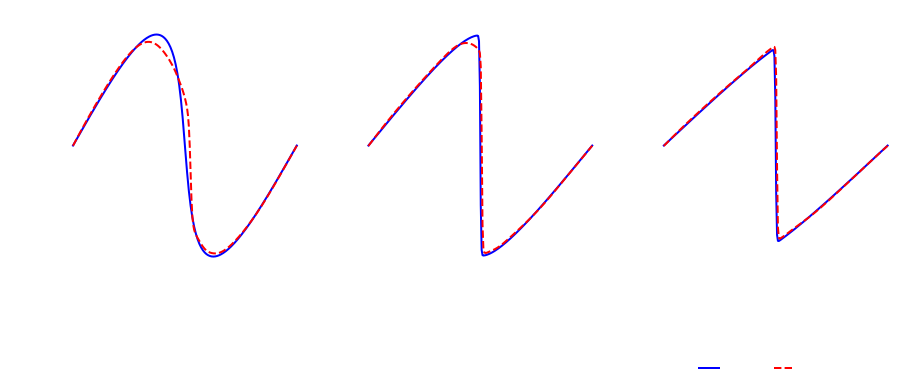

In [68]:
plot_actual_vs_predicted([25, 50, 75])

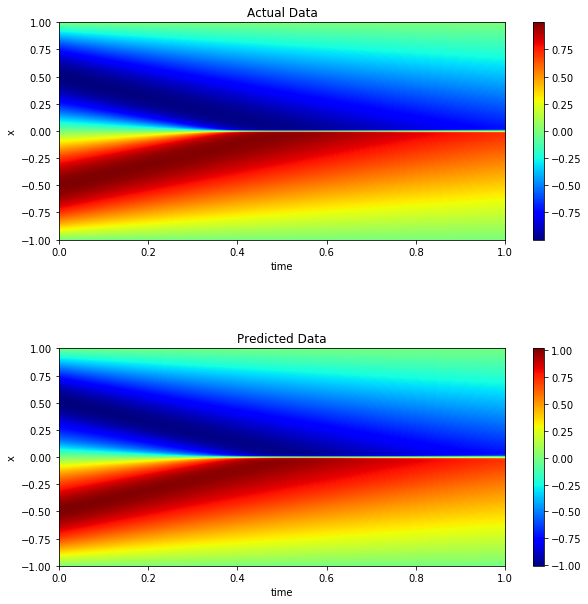

In [90]:
plot_subplots()

## Add Noise to Data

In [91]:
noise = 0.10       
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

In [92]:
model = PhysicsInformedNN(X_u_train, u_train,
                          layers = LAYERS, 
                          num_iter = 500, 
                          lower_bound = lower_bound, upper_bound = upper_bound)
model.train(0)

Loss: 3.951706e-01, l1: 0.00000, l2: 0.00248
Loss: 1.647504e+00, l1: -0.00000, l2: 0.00248
Loss: 3.827433e-01, l1: -0.00000, l2: 0.00248
Loss: 3.827427e-01, l1: -0.00000, l2: 0.00248
Loss: 3.827427e-01, l1: -0.00000, l2: 0.00248
Loss: 3.827423e-01, l1: -0.00000, l2: 0.00248
Loss: 3.827413e-01, l1: 0.00000, l2: 0.00248
Loss: 3.827369e-01, l1: 0.00000, l2: 0.00248
Loss: 3.827282e-01, l1: 0.00000, l2: 0.00248
Loss: 3.827118e-01, l1: 0.00000, l2: 0.00248
Loss: 3.826911e-01, l1: 0.00000, l2: 0.00248
Loss: 3.826771e-01, l1: 0.00000, l2: 0.00248
Loss: 3.826741e-01, l1: 0.00000, l2: 0.00248
Loss: 3.826724e-01, l1: 0.00000, l2: 0.00248
Loss: 3.826666e-01, l1: 0.00000, l2: 0.00248
Loss: 3.826558e-01, l1: 0.00000, l2: 0.00248
Loss: 3.825758e-01, l1: 0.00000, l2: 0.00248
Loss: 3.809080e-01, l1: 0.00000, l2: 0.00248
Loss: 6.108615e-01, l1: 0.00000, l2: 0.00248
Loss: 3.787388e-01, l1: 0.00000, l2: 0.00248
Loss: 3.786096e-01, l1: 0.00000, l2: 0.00248
Loss: 3.786096e-01, l1: 0.00000, l2: 0.00248
Loss:

In [93]:
u_pred = model.predict(X_data)
U_pred = griddata(X_data, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value_noisy = model.sess.run(model.lambda1)
lambda_2_value_noisy = model.sess.run(model.lambda2)
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu)/nu * 100

print('Error lambda_1: %f%%' % (error_lambda_1_noisy))
print('Error lambda_2: %f%%' % (error_lambda_2_noisy))                            

Error lambda_1: 99.999985%
Error lambda_2: 22.127703%


In [94]:
display_PDEs(lambda_1_value, lambda_2_value, 
             lambda_1_value_noisy, lambda_2_value_noisy,
             noise = True)

Correct PDE:
u_t + u u_x - 0.0031831 u_{xx} = 0
---------------------------------
Identified PDE (clean data)
u_t + 0.969 u u_x - 0.004 u_{xx} = 0
---------------------------------
Identified PDE (noisy data)
u_t + 0.000 u u_x - 0.002 u_{xx} = 0


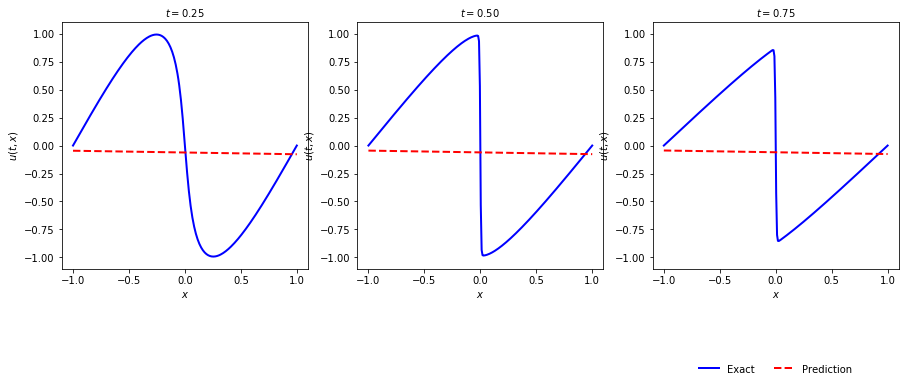

In [95]:
plot_actual_vs_predicted([25, 50, 75])

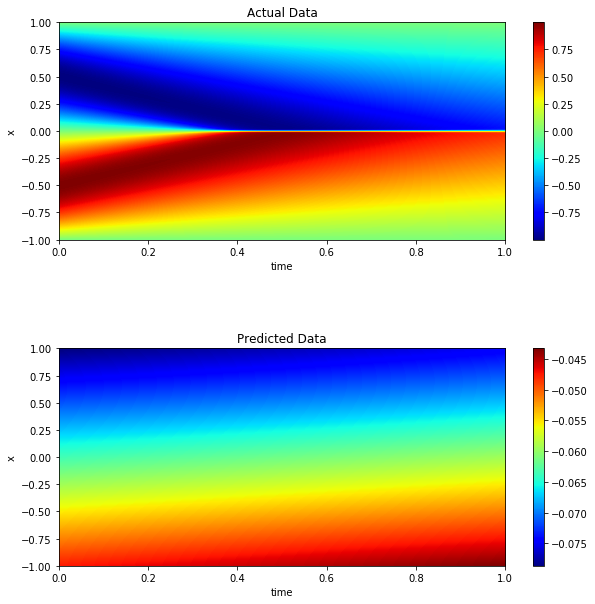

In [96]:
plot_subplots()